# Population Balance Equation: cell division and expansion in tomato

PINN reimplementation of the notebook https://github.com/LeonardoMiele/FruitGrowth/blob/main/Tomate_PBE.ipynb which accompanies the article  **Cell expansion-division under resource sharing: a novel framework for modeling fruit growth dynamics**, Leonardo Miele, Lionel Roques, Dario Constantinescu, Michel Génard, Nadia Bertin (https://doi.org/10.1101/2024.05.30.596571)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Import our package

In [2]:
import jinns


Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


2024-11-19 12:35:03.245761: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create a DataGenerator object

In [4]:
rar_parameters = {
    'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
    'update_every': 100, # nb of gradient steps between two RAR procedures
    'sample_size': 500, # the number of new candidates time points
    'selected_sample_size': 25, # the number of selected times collocation points from the sample, to join the dataset.
}
n_start = 500 # the initial number of  collocation points at beginning

In [5]:
n = 5000
nb = 5000
ni = 5000
domain_batch_size = 256
initial_batch_size = 256
border_batch_size = 256
dim = 1
xmin = 0
xmax = 1
tmin = 0
tmax = 1
method = "grid"

Tmax = 10
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
    rar_parameters=rar_parameters,
    n_start=n_start
)


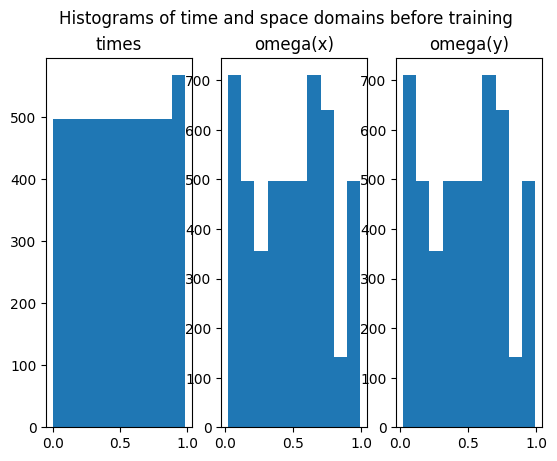

In [6]:
fig, ax = plt.subplots(1, 3)
ax[0].set_scale('log')
ax[0].hist(train_data.domain[:, 0].flatten())
ax[0].set_title('times')
ax[1].set_scale('log')
ax[1].hist(train_data.domain[:, 1].flatten())
ax[1].set_title('omega(x)')
ax[2].set_scale('log')
ax[2].hist(train_data.domain[:, 2].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains before training')
plt.savefig("hist_data_before.pdf")
plt.show()

In [7]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 2],
    #[jnp.exp] #[jax.nn.softplus]
]
key, subkey = random.split(key)
# HARD constraint to enforce 0 at x=0
output_transform = lambda pinn_in, pinn_out, _: (
         (xmax - pinn_in[1]) / (xmax - xmin) * 0.
         + (pinn_in[1] - xmin) * pinn_out


         #    + (pinn_in[1] - xmin) / (xmax - xmin) * 0.
         #+ (pinn_in[1] - xmin) * (xmax - pinn_in[1]) * pinn_out

     )
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(
    key=subkey, eqx_list=eqx_list, eq_type="nonstatio_PDE", dim_x=1,
    #output_transform=output_transform
)

## Set up the initial condition

In [8]:
SCALE = 1e6

In [9]:
# Initial condition parameters
x0 = 0.1
K2 = 1e2
kk = 223.2
n = 12
cell_num0 = 3300

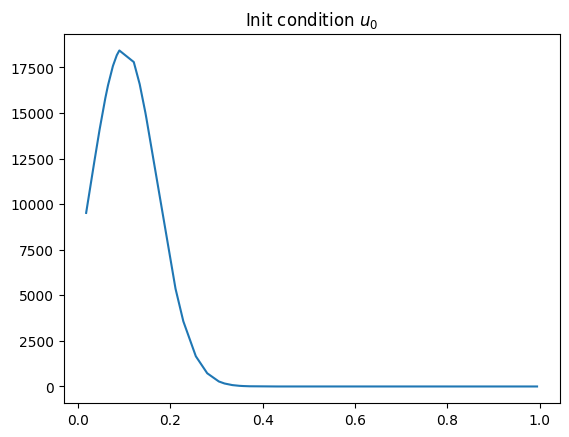

In [24]:
def u0(x):
    nP = cell_num0 * jnp.sqrt(K2) * jnp.exp(-K2 * (x[0] - x0) ** 2) / jnp.sqrt(jnp.pi)
    nQ = jnp.zeros_like(x[0])
    return jnp.array([nP, nQ]) / SCALE

v_u0 = jax.vmap(u0)

plt.plot(train_data.domain[:, 1:2].sort(axis=0), SCALE * jnp.sum(v_u0(train_data.domain[:, 1:2].sort(axis=0)), axis=1))
plt.title(r"Init condition $u_0$")
plt.show()

## Model parameters

In [11]:
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "r":jnp.array(0.3301),
        "rho":jnp.array(0.6143),
        "K":jnp.array(9.8137*1e6),
        "h":jnp.array(0.1044),
        "omega":jnp.zeros((domain_batch_size,)) # just a place holder for the non local quantity 
    }
)

## Loss construction

In [12]:
from jinns.loss._DynamicLossAbstract import PDENonStatio

class PBETomato(PDENonStatio):

    def __init__(self, Tmax=1):
        super().__init__(Tmax=Tmax)
    def equation(self, t_x, u, params):

        omega = 1 - params.eq_params["omega"] / (params.eq_params["K"] / SCALE)
        def phi(x):
            return params.eq_params["r"] * x ** (2/3)
        def gamma(x):
            n = 12
            gamma0 = 223.2
            return gamma0 * x ** n / (params.eq_params["h"] ** n + x ** n)
        

        nP = lambda t_x: u(t_x, params)[0]
        nQ = lambda t_x: u(t_x, params)[1]
        dnP_dt = jax.grad(nP)(t_x)[0]
        dnQ_dt = jax.grad(nQ)(t_x)[0]
        dPhinP_dx = jax.grad(lambda t_x: phi(t_x[1]) * nP(t_x))(t_x)[1]
        dPhinQ_dx = jax.grad(lambda t_x: phi(t_x[1]) * nQ(t_x))(t_x)[1]

        dyn_lossP = -dnP_dt + self.Tmax * (omega * (-dPhinP_dx
                        + 4 * gamma(2 * t_x[1]) * nP(jnp.array([1, 2]) * t_x)
                        - gamma(t_x[1]) * nP(t_x))
                        - params.eq_params["rho"] * nP(t_x)
        )
        #dyn_lossP = -dnP_dt + self.Tmax * params["eq_params"]["rho"] * nP(t, x)
        dyn_lossQ = -dnQ_dt + self.Tmax * (omega * (-dPhinQ_dx)
                        + params.eq_params["rho"] * nP(t_x)
        )
        return jnp.stack([dyn_lossP, dyn_lossQ], axis=0)

pbe_tomato = PBETomato(Tmax=Tmax)

In [13]:
from jinns.loss._LossPDE import LossPDENonStatio
from jinns.parameters._derivative_keys import _set_derivatives
from jinns.loss._loss_utils import *
from jinns.parameters._params import _get_vmap_in_axes_params

class NonLocalLossPDENonStatio(LossPDENonStatio):
    
    def __post_init__(self, params=None):
        super().__post_init__(params=params)


    def evaluate(
        self,
        params,
        batch,
    ):

        vmap_in_axes_params = _get_vmap_in_axes_params(batch.param_batch_dict, params)

        # Compute the non local term using the argument `norm_samples`
        # We compute for all the time points in the batch
        # The double vmap enables to have different size for t (which will be the temporal_batch_size)
        # and for x which will be `norm_samples`
        time_batch = batch.domain_batch[:, 0:1]
        norm_samples = self.norm_samples
        batches = make_cartesian_product(
            time_batch,
            norm_samples,
        ).reshape(time_batch.shape[0], norm_samples.shape[0], -1)
        v_S = vmap(
            vmap(
                lambda t_x, params_: jnp.sum(self.u(t_x, params_)) * t_x[1] ** (2/3),
                in_axes=(0,) + vmap_in_axes_params,
            ),
            in_axes=(0,) + vmap_in_axes_params,
        )
        params_ = _set_derivatives(params, self.derivative_keys.dyn_loss)
        params_ = eqx.tree_at(
            lambda p:p.eq_params,
            params_,
            {
                "r":jnp.array(0.3301),
                "rho":jnp.array(0.6143),
                "K":jnp.array(9.8137*1e6),
                "h":jnp.array(0.1044),
                "omega":self.norm_int_length * jnp.mean(v_S(batches, params_).squeeze(), axis=-1) 
            }
        )
        # When computing the dynamic loss only we have batch of omega for the dynamic loss
        
        vmap_in_axes_params_dynamic = (jinns.parameters.Params(
            nn_params=None,
            eq_params={k: (0 if k == "omega" else None) for k in params_.eq_params.keys()}
        ),)
        # dynamic part
        if self.dynamic_loss is not None:
            mse_dyn_loss = dynamic_loss_apply(
                self.dynamic_loss.evaluate,
                self.u,
                self._get_dynamic_loss_batch(batch),
                params_,
                self.vmap_in_axes + vmap_in_axes_params_dynamic,
                self.loss_weights.dyn_loss
            )
        else:
            mse_dyn_loss = jnp.array(0.0)

        # boundary part
        if self.omega_boundary_fun is not None:
            mse_boundary_loss = boundary_condition_apply(
                self.u,
                batch,
                _set_derivatives(params, self.derivative_keys.boundary_loss),
                self.omega_boundary_fun,
                self.omega_boundary_condition,
                self.omega_boundary_dim,
                self.loss_weights.boundary_loss,
            )
        else:
            mse_boundary_loss = jnp.array(0.0)

        # initial condition
        if self.initial_condition_fun is not None:
            mse_initial_condition = initial_condition_apply(
                self.u,
                batch.initial_batch,
                _set_derivatives(params, self.derivative_keys.initial_condition),
                (0,) + vmap_in_axes_params,
                self.initial_condition_fun,
                self.loss_weights.initial_condition,
            )
        else:
            mse_initial_condition = jnp.array(0.0)

        # total loss
        total_loss = (
            mse_dyn_loss
            + mse_boundary_loss
            + mse_initial_condition
        )
        #jax.debug.print("{x}", x=(mse_dyn_loss, mse_boundary_loss, mse_initial_condition))
        return total_loss, (
            {
                "dyn_loss": mse_dyn_loss,
                "norm_loss": 0.,
                "boundary_loss": mse_boundary_loss,
                "initial_condition": mse_initial_condition,
                "observations": 0.,
                "sobolev": 0.,
            }
        )

Loss for the PINN

In [14]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,
    initial_condition=1,# * Tmax,
    boundary_loss=1, #* Tmax
)

omega_boundary_fun = {
    "xmin": lambda t_x: jnp.array([0.0, 0.0]),
    "xmax": None,
}
omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": None,
}

key, subkey = jax.random.split(key, 2)
MC_samples = random.uniform(
            subkey, shape = (500, 1), minval=xmin, maxval=xmax
        )
loss_pinn = NonLocalLossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=pbe_tomato,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    initial_condition_fun=u0,
    norm_int_length=(xmax - xmin),
    norm_samples=MC_samples,
    params=init_params_pinn
)

## Learning the neural network parameters

### Train the PINN and plot loss values and solution

In [15]:
params_pinn = init_params_pinn
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-4)
n_iter = 30000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
)


Compilation took
 7.944529056549072 

[train] Iteration 0: loss value = 139953.625
[train] Iteration 1000: loss value = 0.027255810797214508
[train] Iteration 2000: loss value = 0.015048852190375328
[train] Iteration 3000: loss value = 0.23246261477470398
[train] Iteration 4000: loss value = 0.04469366744160652
[train] Iteration 5000: loss value = 0.023318076506257057
[train] Iteration 6000: loss value = 0.011404472403228283
[train] Iteration 7000: loss value = 0.007293727248907089
[train] Iteration 8000: loss value = 0.006331495009362698
[train] Iteration 9000: loss value = 0.003296004608273506
[train] Iteration 10000: loss value = 0.0030181987676769495
[train] Iteration 11000: loss value = 0.036463409662246704
[train] Iteration 12000: loss value = 0.004909220151603222
[train] Iteration 13000: loss value = 0.1274745762348175
[train] Iteration 14000: loss value = 0.15103447437286377
[train] Iteration 15000: loss value = 0.0006524627096951008
[train] Iteration 16000: loss value = 0.002

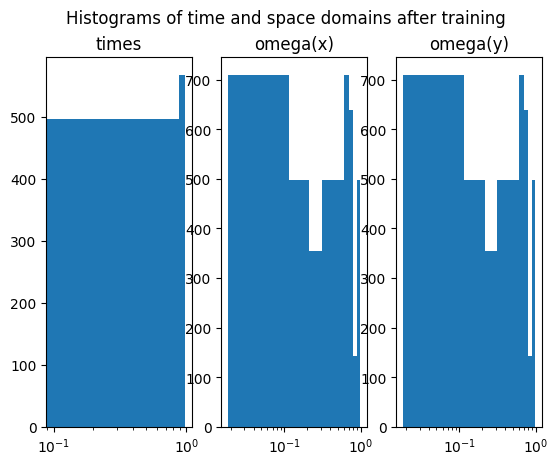

In [16]:
fig, ax = plt.subplots(1, 3)
ax[0].set_xscale('log')
ax[0].hist(train_data.domain[:, 0].flatten())
ax[0].set_title('times')
ax[1].set_xscale('log')
ax[1].hist(train_data.domain[:, 1].flatten())
ax[1].set_title('omega(x)')
ax[2].set_xscale('log')
ax[2].hist(train_data.domain[:, 2].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains after training')
plt.show()

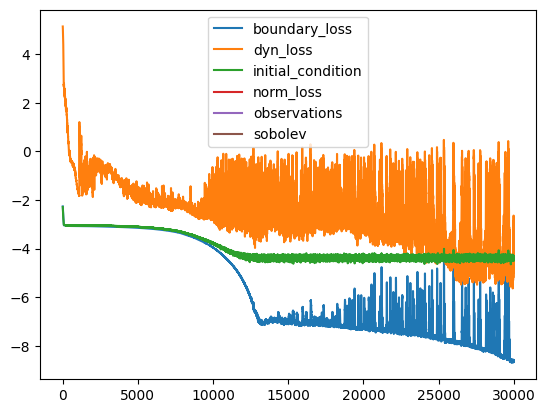

In [17]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
#plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [18]:
print(train_data.domain[:, 1].shape, jnp.min(train_data.domain[:, 1]), jnp.max(train_data.domain[:, 1]))

(5041,) 0.018111587 0.99404097


In [19]:
nx = 500
val_xdata = jnp.linspace(jnp.min(train_data.domain[:, 1]), jnp.max(train_data.domain[:, 1]), nx)
print(val_xdata.shape, jnp.min(val_xdata), jnp.max(val_xdata))
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

(500,) 0.018111587 0.99404097


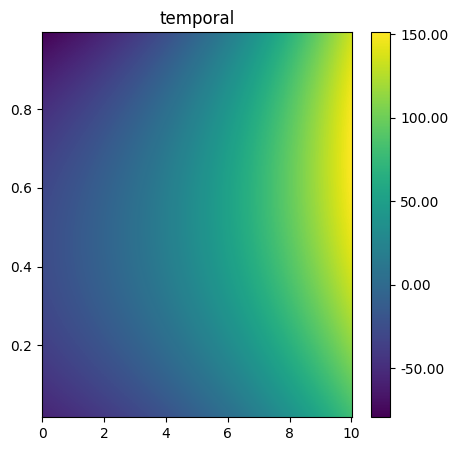

In [20]:
u_est_pinn_nP = lambda t_x: u_pinn(t_x, params_pinn.nn_params)[0] * SCALE
u_est_pinn_nQ = lambda t_x: u_pinn(t_x, params_pinn.nn_params)[1] * SCALE

u_est_pinn = lambda t_x: u_est_pinn_nP(t_x) + u_est_pinn_nQ(t_x)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal")

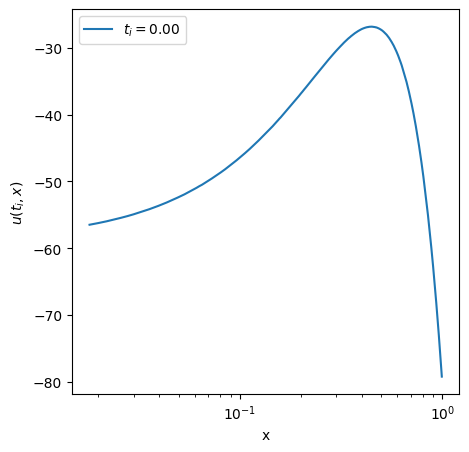

In [23]:
time_slices = [0.]#, 0.2, 0.4, 1]

# rewrite the plot1d_slices from jinns.data_display in order to put a semilogx command
plt.figure(figsize=(5,5))
for t in time_slices:
    t_ = jnp.ones(val_xdata.shape) * t
    v_u = vmap(u_est_pinn)
    values = v_u(jnp.stack([t_, val_xdata]).T)
    plt.semilogx(val_xdata, values, label=f"$t_i={t * Tmax:.2f}$")
    plt.xlabel("x")
    plt.ylabel(r"$u(t_i, x)$")
    plt.legend()
    plt.title("")
